In [1]:
# %%writefile pickle_numerical_gb_model.py
'''
This script pickles the Gradient Boosting model trained on the categorical and 
continuous values for bills that have moved beyond bill_status Introduced. The 
predicted probabilities will be used in feature-weighted linear stacking with the
probabilities calculated in the nlp model to improve predictions on those.
'''
import pandas as pd
import numpy as np
from my_tools import get_bill_data
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, confusion_matrix, log_loss, roc_curve, roc_auc_score



/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
data, in_progress = get_bill_data()

# fit to bills that have moved beyond bill_status Introduced
data = data[data['bill_status'] != 'Introduced']

print('------------------')
print('Limiting dataset to significant numerical and categorical features...')

cols_to_use = [
#             'sponsor',
            'num_of_cosponsors', 
#             'sponsor_party', 
#             'sponsor_state', 
            'num_of_amendments',
            'bill_char_counts', 
            'intro_month', 
            'session', 
            'labels'
            ]

dummy_columns = [
            'intro_month', 
#             'num_of_amendments', 
#             'num_of_cosponsors',
#             'sponsor',
#             'sponsor_party', 
#             'sponsor_state', 
            'session'
            ]

data_features = data.loc[:, cols_to_use]

# get dummies for intro_month, sponsor_party, sponsor_state, session
data_dumm = pd.get_dummies(data_features, columns = dummy_columns, drop_first=False)


# drop last dummy column for each feature to avoid dummy trap
cols_to_drop = ['intro_month_12', 'session_2']
for col in cols_to_drop: 
    data_dumm.drop(col, axis = 1, inplace = True)



------------------
Limiting dataset to significant numerical and categorical features...


In [3]:
# y = data_features.pop('labels').values.astype(int)
y = data_dumm.pop('labels').values.astype(int)

In [4]:
print('------------------')
print('Performing train-test split...')
X_train, X_test, y_train, y_test = train_test_split(data_dumm, y, stratify = y)
# X_train, X_test, y_train, y_test = train_test_split(data_features, y, stratify = y)

print('------------------')
print('Scaling the data...')
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)



print('-------------------')
print('Training Gradient Boosting Classifier with continuous and categorical data...')
gb = GradientBoostingClassifier(loss= 'deviance',             # default value
                                max_features = None,          # default value
                                learning_rate = .05,
                                n_estimators = 200,           # default value
                                criterion = 'friedman_mse',   # default value
                                min_samples_split = 2,        # default value
                                min_samples_leaf = 1,         # default value
                                max_depth = 8,
                                max_leaf_nodes = None)        # default value

gb.fit(X_train, y_train)

print('-------------------')
print('Getting predictions...')
gb_y_pred = gb.predict(X_test)
gb_y_pred_proba = gb.predict_proba(X_test)[:, 1]

print('-------------------')
print('F1 Score:\t\t{:.4f}'.format(f1_score(y_test, gb_y_pred)))
print('Recall Score:\t\t{:.4f}'.format(recall_score(y_test, gb_y_pred)))
print('Precision Score:\t{:.4f}'.format(precision_score(y_test, gb_y_pred)))
print('Accuracy Score:\t\t{:.4f}'.format(accuracy_score(y_test, gb_y_pred)))
print(confusion_matrix(y_test, gb_y_pred))

gb_fprs, gb_tprs, gb_thresh = roc_curve(y_test, gb_y_pred_proba)

# fit data to Logistic Regression
print('-------------------')
print('Training Logistic regression with continuous and categorical data...')
lr = LogisticRegression(C = 100, 
                        n_jobs = -1, 
                        class_weight = 'balanced')
lr.fit(X_train, y_train)

print('-------------------')
print('Getting predictions...')
lr_y_pred = lr.predict(X_test)
lr_y_pred_proba = lr.predict_proba(X_test)[:,1]

print('-------------------')
print('F1 Score:\t\t{:.4f}'.format(f1_score(y_test, lr_y_pred)))
print('Recall Score:\t\t{:.4f}'.format(recall_score(y_test, lr_y_pred)))
print('Precision Score:\t{:.4f}'.format(precision_score(y_test, lr_y_pred)))
print('Accuracy Score:\t\t{:.4f}'.format(accuracy_score(y_test, lr_y_pred)))
print('Confusion Matrix')
print(confusion_matrix(y_test, lr_y_pred))

lr_fprs, lr_tprs, lr_thresh = roc_curve(y_test, lr_y_pred_proba)

------------------
Performing train-test split...
------------------
Scaling the data...
-------------------
Training Gradient Boosting Classifier with continuous and categorical data...
-------------------
Getting predictions...
-------------------
F1 Score:		0.5087
Recall Score:		0.4307
Precision Score:	0.6213
Accuracy Score:		0.6924
[[780 142]
 [308 233]]
-------------------
Training Logistic regression with continuous and categorical data...
-------------------
Getting predictions...
-------------------
F1 Score:		0.4252
Recall Score:		0.4492
Precision Score:	0.4037
Accuracy Score:		0.5509
Confusion Matrix
[[563 359]
 [298 243]]


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


---------------------------
With all data (2007 - 2018)
---------------------------
Logistic Regression ROC AUC Score: 	0.5330
GradientBoost ROC AUC Score: 		0.6855


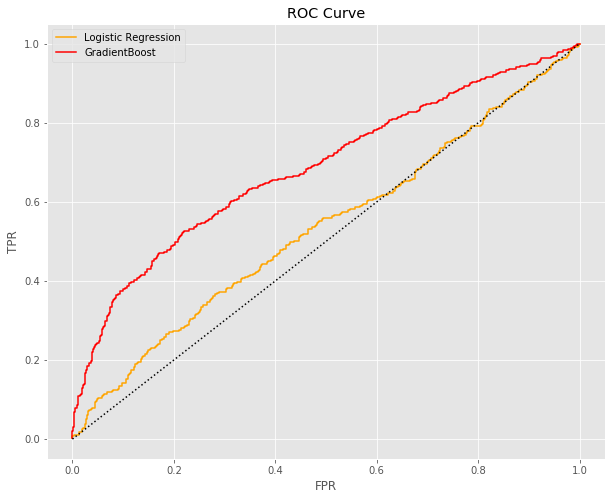

In [5]:
print('---------------------------')
print('With all data (2007 - 2018)')
print('---------------------------')
fig = plt.figure(figsize = (10, 8))
plt.plot(lr_fprs, lr_tprs, label = 'Logistic Regression', color = 'orange')
plt.plot(gb_fprs, gb_tprs, label = 'GradientBoost', color = 'red')
plt.plot([0, 1], [0, 1], 'k:')
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

print('Logistic Regression ROC AUC Score: \t{:.4f}'.format(roc_auc_score(y_test, lr_y_pred_proba)))
print('GradientBoost ROC AUC Score: \t\t{:.4f}'.format(roc_auc_score(y_test, gb_y_pred_proba)))



In [6]:
# fit new bills that have moved beyond bill_status Introduced
new_data = in_progress[in_progress['bill_status'] != 'Introduced']


print('------------------')
print('Limiting dataset to significant numerical and categorical features...')
new_data_features = new_data.loc[:, cols_to_use]

------------------
Limiting dataset to significant numerical and categorical features...


In [7]:
# get dummies for intro_month, sponsor_party, sponsor_state, session
new_data_dumm = pd.get_dummies(new_data_features, columns = dummy_columns, 
                           drop_first=False)


# modify columns to fit model
new_data_dumm.drop('labels', axis = 1, inplace = True)
for col in data_dumm.columns:
    if col not in new_data_dumm.columns:
        new_data_dumm[col] = 0

In [8]:
new_data_dumm

,num_of_cosponsors,num_of_amendments,bill_char_counts,intro_month_1,session_1,intro_month_2,intro_month_3,intro_month_4,intro_month_5,intro_month_6,intro_month_7,intro_month_8,intro_month_9,intro_month_10,intro_month_11
2,0,0,4577,1,1,0,0,0,0,0,0,0,0,0,0
25,0,0,1295706,1,1,0,0,0,0,0,0,0,0,0,0


In [9]:
print('-------------------')
print('Getting predictions...')
gb_y_pred = gb.predict(new_data_dumm)
gb_y_pred_proba = gb.predict_proba(new_data_dumm)[:, 1]


-------------------
Getting predictions...


In [10]:
print('-------------------')
print('Getting predictions...')
lr_y_pred = lr.predict(new_data_dumm)
lr_y_pred_proba = lr.predict_proba(new_data_dumm)[:, 1]


-------------------
Getting predictions...


In [11]:
gb_y_pred_proba

array([0.93413942, 0.93413942])

In [12]:
lr_y_pred_proba

array([1., 1.])

In [13]:
new_data_dumm.shape

(2, 15)

In [14]:
new_data

,_id,bill_status,bill_text,body,committee,congress_id,cosponsors,cosponsors_url,desc,intro_date,...,sponsor,sponsor_district,sponsor_party,sponsor_state,bill_char_counts,intro_month,intro_year,session,char_count_bucket,labels
2,5c2fb9ca1417de116c271913,Passed House,Making further continuing appropriations for t...,[Congressional Bills 116th Congress] [From the...,House - Appropriations,116,None,None,Making further continuing appropriations for t...,2019-01-03,...,"Lowey, Nita M.",17,D,NY,4577,1,2019,1,4001 - 5000,in_progress
25,5c2fb9c21417de116c2718fd,Passed House,Making appropriations for the fiscal year endi...,[Congressional Bills 116th Congress] [From the...,"House - Appropriations, Budget",116,None,None,"Consolidated Appropriations Act, 2019",2019-01-03,...,"Lowey, Nita M.",17,D,NY,1295706,1,2019,1,greater than 10000,in_progress
